# FCIQMC (Full Configuration Interaction Quantum Monte Carlo)

論文 [Fermion Monte Carlo without fixed nodes: A game of life, death, and
annihilation in Slater determinant space](https://2024.sci-hub.st/1534/f26924b07d1005f6f9a7be1b525feec7/booth2009.pdf) を読み、Pythonでの実装を試みる。

## 準備

```
$ conda install tqdm pandas
$ conda install -c conda-forge pyscf
```

## 共通の関数を定義

In [52]:
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from pyscf import gto, scf, fci, ao2mo
import random

rng = np.random.default_rng()

def build_hamiltonian(mol):
    E_nuc = mol.energy_nuc()
    # print("E_nuc:", E_nuc)
    elec_num = sum(mol.nelec)
    myhf = mol.HF()
    myhf.kernel()
    mymp2 = myhf.MP2()
    mymp2.kernel() # run mp2
    C = myhf.mo_coeff # molecular coefficient matrix
    h1 = np.matmul((C.T),np.matmul((myhf.get_hcore()),(C)))
    h2 = ao2mo.kernel(mol,C)
    h2 = ao2mo.restore(8,h2,mol.nao_nr())

    H_mat = fci.direct_spin1.pspace(h1, h2, mol.nao_nr(), elec_num, np=70000)[1] # creates Hamiltonian
    H_mat = H_mat + E_nuc * np.eye(H_mat.shape[0])
    nspatorbs = int(mol.nao_nr())

    # --- フル FCI エネルギー ---
    cis = fci.FCI(myhf)
    E_fci, civec = cis.kernel(h1, h2, C.shape[1], mol.nelec)
    E_HF = myhf.e_tot

    return H_mat, E_fci, E_HF

# mol = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='sto-3g', verbose=0)
# H_mat, E_fci, E_HF = build_hamiltonian(mol)
# print(H_mat)


def FCIQMC(mol, shift=0, init_n_walker=1, n_steps=5000, step_starting_shift_upd=500, n_prod=2500,
           shift_upd_interval=10, dt=0.001, damping=0.05):
    """
    Full Configuration Interaction Quantum Monte Carlo (FCIQMC) を用いて基底状態エネルギーを推定する。

    Args:
        mol: PySCFのMoleculeオブジェクト
        shift: 初期シフト値 S(0)。ウォーカー数の増減を抑制するためのエネルギー的バイアス
        init_n_walker: 初期状態（参照決定基）に配置するウォーカー数
        n_steps: シミュレーションの総ステップ数
        step_starting_shift_upd: Shift の更新を開始するステップ。初期緩和期間としてこのステップまでは shift を固定する。
        shift_upd_interval: Shift をどの頻度で更新するか（ステップ単位）。例えば 10 なら、10 ステップごとに shift を更新する。
        n_prod: E_projの平均を計算するステップ数（処理完了時からこのステップ数遡って平均を取る）
        dt: imaginary time step（時間刻み）。小さいほど安定するが計算コストが増える
        damping: Shift更新時の更新の程度表すパラメータ
        

    Returns:
        tuple:
            - **E_est (float)**: 最終 1000 ステップの projected energy の平均（推定エネルギー）
            - **hist_population (list[int])**: 各ステップのウォーカー総数の履歴
            - **hist_shift (list[float])**: 各ステップの shift の履歴
            - **hist_energy (list[float])**: 各ステップの projected energy の履歴
    """    
    H_mat, E_fci, E_HF = build_hamiltonian(mol)
    # H_mat = np.array([
    #     [-1.13727,  0.0,      0.18129, -0.18129,  0.0,      0.0     ],
    #     [ 0.0,     -0.51055,  0.0,      0.0,      0.0,      0.0     ],
    #     [ 0.18129,  0.0,     -0.67894,  0.0,      0.0,      0.18129 ],
    #     [-0.18129,  0.0,      0.0,     -0.67894,  0.0,     -0.18129 ],
    #     [ 0.0,      0.0,      0.0,      0.0,     -0.51055,  0.0     ],
    #     [ 0.0,      0.0,      0.18129, -0.18129,  0.0,     -0.16889]
    # ])
    # E_HF = H_mat[0, 0]
    print(f"--- FCI Matrix ---")
    print(H_mat.shape)
    print(H_mat)
    

    # print('E_HF:', E_HF)
    H_mat = H_mat - np.eye(H_mat.shape[0]) * E_HF
    print(f"--- K Matrix ---")
    print(H_mat)
    
    E_est = 0
    hist_population, hist_shift, hist_energy = [], [], []
    
    diag_H = np.diag(H_mat)    
    pre_shift = shift
    pre_pop = init_n_walker

    # 基底状態（Hartree-Fock解）のインデックスを特定
    # PySCFのFCIでは通常、最初の行列要素がHF状態に対応します
    ref_det_idx = 0 
        
    # ウォーカーの初期化 {det_index: signed_population}
    # 符号付き整数で管理（+1, -1など）
    walkers = {ref_det_idx: init_n_walker}

    print('\n---- Initial walkers ----')
    for k, v in walkers.items():
        tqdm.write(f"{v} walkers on {k}th determinant")

    
    for step in tqdm(range(n_steps)):
        new_walkers = defaultdict(int)
        
        # walkersが乗っている行列式の全てのインデックスを取得
        current_dets = list(walkers.keys())
        # if step % 1000 == 0:
        #     tqdm.write(f"current_dets: {current_dets}")

        
        for i in current_dets:
            n_i = walkers[i] # ith行列式上のウォーカー数（符号付き）
            if n_i == 0: continue

            # ----- Spawning Step -----
            row = H_mat[i]
            # 非ゼロ要素のインデックスを取得
            connected_dets = np.where(row != 0)[0]
            # 対角要素は自分自身への遷移を表すので処理しない
            connected_dets = connected_dets[connected_dets != i]
            # ランダムに遷移先determinant jを候補に選ぶ
            j = np.random.choice(connected_dets)
            h_ij = row[j]

            # Spawning probability: Ps = dt * |H_ij|
            # 生成される数: sign(walker) * sign(-H_ij)
            p_gen = 1/len(connected_dets)
            prob_spawn = dt * abs(h_ij) / p_gen

            # 全てのwalkerに対して、spawnを試みる
            n_spawn = np.full(abs(n_i), 0)
            prob_spawn_frac, prob_spawn_int = math.modf(prob_spawn)
            if prob_spawn_int > 1:
                n_spawn = np.full(abs(n_i), prob_spawn_int)
            n_spawn += (np.random.rand(abs(n_i)) <= prob_spawn).astype(int)
            
            # h_ij>0ならば親と異符号、h_ij<0ならば親と同符号のwalkerを遷移先jth行列式の上に生成
            if h_ij > 0:
                new_walkers[j] += -np.sign(n_i) * np.sum(n_spawn)
            else:
                new_walkers[j] += np.sign(n_i) * np.sum(n_spawn)


            # ----- Diagonal Step (Death/Cloning) -----
            # Pd = exp(-dt * (H_ii - S)) - 1  ~ -dt * (H_ii - S)
            h_ii = diag_H[i]
            prob_death = dt * (h_ii - shift)
            n_walker_on_D = n_i
            sign = np.sign(n_walker_on_D)

            # prob_deathの確率でdeath/cloneする（対象となるwalkerの数をカウントする）
            count = np.sum(np.random.rand(abs(n_i)) <= abs(prob_death))
            if prob_death > 0:
                # prob_deathが正ならwalkerをcount分消滅させる
                n_walker_on_D = sign * (abs(n_walker_on_D) - count)
            else:
                # prob_deathが負ならwalkerをcount分複製する
                n_walker_on_D = sign * (abs(n_walker_on_D) + count)    
            walkers[i] = n_walker_on_D
            

        # ----- Annihilation Step -----
        for idx, n in new_walkers.items():
            walkers[idx] = walkers.get(idx, 0) + n

        # ---- Shift Update -----
        current_pop = sum(abs(w) for w in walkers.values())
        if step > step_starting_shift_upd: # 初期緩和後
            if step % shift_upd_interval == 0:
                shift = pre_shift - (damping / (shift_upd_interval*dt)) * np.log(current_pop / pre_pop)
                pre_shift = shift
        hist_shift.append(shift)
        pre_pop = current_pop
        hist_population.append(current_pop)
        
        # ----- Energy Estimation (Projected Energy) -----
        # E_HF2 = diag_H[ref_det_idx]  # これはE_HFではない
        row0 = H_mat[ref_det_idx]
        num_ref = walkers.get(ref_det_idx, 0)

        # 論文では、singles/doublesに限定して合計している
        # この実装だとそもそもFCI行列の成分がsingles/doubles以外が0になっているので、
        # 全部を合計していて、結局singles/doublesだけが合計されることになっている
        E_proj = E_HF + sum(row0[idx]*v/num_ref for idx, v in walkers.items() if idx != ref_det_idx)
        
        # 生成したコードでは論文にはない項を足していた
        # これはハミルトニアンに各反発エネルギーが含まれているかいないかの解釈が論文と異なっているため？
        # これを含めなければ近い値に収束するので、コメントアウトしておく
        # E_proj += mol.energy_nuc()
        hist_energy.append(E_proj)
        
        if step % 1000 == 0:
            tqdm.write(f"Step {step}: Walkers={current_pop}, Shift={shift:.5f}, E_proj={E_proj:.6f}")
            for k, v in walkers.items():
                if v != 0:
                    tqdm.write(f"  {v} walkers on {k}th determinant")

    E_est = np.mean(hist_energy[-n_prod:]) # 最後のn_prodステップの平均
    avg_shift = np.mean(hist_shift[-n_prod:]) # 最後のn_prodステップの平均
    
    print('\n---- Walkers (result) ----')
    for k, v in walkers.items():
        if v != 0:
            print(f"{v} walkers on {k}th determinant")

    return E_est, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy


def plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy):
    plt.figure(figsize=(10, 6))
    plt.plot(hist_population)
    plt.xlabel('Step')
    plt.ylabel('Population')
    plt.yscale('log')

    E_corr = np.full_like(hist_shift, E_fci - E_HF)
    plt.figure(figsize=(10, 6))
    plt.plot(hist_shift, label="Shift")
    plt.plot(E_corr, linestyle="--", label=r"${E_{corr}}$")
    plt.xlabel('Step')
    plt.ylabel('Shift')
    plt.legend()

    E_fci_arr = np.full_like(hist_energy, E_fci)
    plt.figure(figsize=(10, 6))
    plt.plot(hist_energy, label=r"${E_{proj}}$")
    plt.plot(E_fci_arr, linestyle="--", label=r"${E_{FCI}}$")
    plt.xlabel('Step')
    plt.ylabel('Projected Energy')
    plt.legend()
    
    plt.show()

## ${H_2}$ 分子 STO-3G

FCIによる基底エネルギーは -1.1373 で、FCIQMCによる推定基底エネルギーは近い値が出るが、Shiftが下がり続け、${E_{corr}}$の値に収束しない（原因不明）。

--- FCI Matrix ---
(4, 4)
[[-1.11675931e+00 -3.63850793e-16 -3.63850793e-16  1.81210462e-01]
 [-3.63850793e-16 -3.49562895e-01  1.81210462e-01  1.90003444e-16]
 [-3.63850793e-16  1.81210462e-01 -3.49562895e-01  1.90003444e-16]
 [ 1.81210462e-01  1.90003444e-16  1.90003444e-16  4.62618146e-01]]
--- K Matrix ---
[[ 0.00000000e+00 -3.63850793e-16 -3.63850793e-16  1.81210462e-01]
 [-3.63850793e-16  7.67196412e-01  1.81210462e-01  1.90003444e-16]
 [-3.63850793e-16  1.81210462e-01  7.67196412e-01  1.90003444e-16]
 [ 1.81210462e-01  1.90003444e-16  1.90003444e-16  1.57937745e+00]]

---- Initial walkers ----
10 walkers on 0th determinant


  7%|██████▌                                                                                   | 2204/30000 [00:00<00:01, 22035.56it/s]

j:  3
Step 0: Walkers=10, Shift=0.70000, E_proj=-1.116759
  10 walkers on 0th determinant
j:  3
j:  0
Step 1000: Walkers=31, Shift=0.70000, E_proj=-1.143605
  27 walkers on 0th determinant
  -4 walkers on 3th determinant
j:  2
j:  0
Step 2000: Walkers=67, Shift=0.70000, E_proj=-1.131373
  62 walkers on 0th determinant
  -5 walkers on 3th determinant
j:  1
j:  2
Step 3000: Walkers=130, Shift=0.70000, E_proj=-1.128642
  122 walkers on 0th determinant
  -8 walkers on 3th determinant
j:  1
j:  1
Step 4000: Walkers=275, Shift=0.70000, E_proj=-1.141470
  242 walkers on 0th determinant
  -33 walkers on 3th determinant


 23%|████████████████████▋                                                                     | 6895/30000 [00:00<00:01, 22528.47it/s]

j:  2
j:  1
Step 5000: Walkers=496, Shift=0.70000, E_proj=-1.136624
  447 walkers on 0th determinant
  -49 walkers on 3th determinant
j:  2
j:  0
Step 6000: Walkers=961, Shift=0.70000, E_proj=-1.136871
  865 walkers on 0th determinant
  -96 walkers on 3th determinant
j:  1
j:  1
Step 7000: Walkers=1908, Shift=0.70000, E_proj=-1.137860
  1709 walkers on 0th determinant
  -199 walkers on 3th determinant
j:  2
j:  0
Step 8000: Walkers=3932, Shift=0.70000, E_proj=-1.139242
  3498 walkers on 0th determinant
  -434 walkers on 3th determinant


 30%|███████████████████████████▍                                                              | 9150/30000 [00:00<00:01, 17441.97it/s]

j:  1
j:  1
Step 9000: Walkers=8071, Shift=0.70000, E_proj=-1.137782
  7232 walkers on 0th determinant
  -839 walkers on 3th determinant
j:  1
j:  2
Step 10000: Walkers=16815, Shift=0.70000, E_proj=-1.137087
  15119 walkers on 0th determinant
  -1696 walkers on 3th determinant


 37%|█████████████████████████████████                                                         | 11023/30000 [00:00<00:02, 8929.58it/s]

j:  3
j:  0
Step 11000: Walkers=29474, Shift=0.39686, E_proj=-1.138351
  26336 walkers on 0th determinant
  -3138 walkers on 3th determinant


 37%|█████████████████████████████████                                                         | 11023/30000 [00:01<00:02, 8929.58it/s]

j:  3
j:  0
Step 12000: Walkers=40819, Shift=0.22322, E_proj=-1.137963
  36543 walkers on 0th determinant
  -4276 walkers on 3th determinant


 44%|████████████████████████████████████████                                                  | 13340/30000 [00:02<00:04, 3590.17it/s]

j:  2
j:  2
Step 13000: Walkers=49610, Shift=0.14838, E_proj=-1.137273
  44565 walkers on 0th determinant
  -5045 walkers on 3th determinant


 47%|██████████████████████████████████████████▏                                               | 14046/30000 [00:02<00:05, 2982.43it/s]

j:  3
j:  0
Step 14000: Walkers=56281, Shift=0.07801, E_proj=-1.135881
  50909 walkers on 0th determinant
  -5372 walkers on 3th determinant


 50%|████████████████████████████████████████████▉                                             | 14994/30000 [00:03<00:06, 2317.62it/s]

j:  1
j:  1
Step 15000: Walkers=61173, Shift=0.04435, E_proj=-1.137123
  54993 walkers on 0th determinant
  -6180 walkers on 3th determinant


 54%|████████████████████████████████████████████████▋                                         | 16245/30000 [00:04<00:08, 1679.74it/s]

j:  3
j:  2
Step 16000: Walkers=64766, Shift=0.02348, E_proj=-1.137951
  57985 walkers on 0th determinant
  -6781 walkers on 3th determinant


 57%|███████████████████████████████████████████████████▌                                      | 17170/30000 [00:04<00:08, 1440.76it/s]

j:  3
j:  1
Step 17000: Walkers=67291, Shift=0.01706, E_proj=-1.136997
  60531 walkers on 0th determinant
  -6760 walkers on 3th determinant


 61%|██████████████████████████████████████████████████████▍                                   | 18166/30000 [00:05<00:08, 1412.11it/s]

j:  1
j:  0
Step 18000: Walkers=69235, Shift=-0.00810, E_proj=-1.137203
  62216 walkers on 0th determinant
  -7019 walkers on 3th determinant


 64%|█████████████████████████████████████████████████████████▍                                | 19151/30000 [00:06<00:07, 1388.08it/s]

j:  1
j:  0
Step 19000: Walkers=69558, Shift=-0.01124, E_proj=-1.136480
  62731 walkers on 0th determinant
  -6827 walkers on 3th determinant


 67%|████████████████████████████████████████████████████████████▍                             | 20128/30000 [00:06<00:07, 1378.08it/s]

j:  3
j:  0
Step 20000: Walkers=70408, Shift=-0.01715, E_proj=-1.137785
  63088 walkers on 0th determinant
  -7320 walkers on 3th determinant


 71%|███████████████████████████████████████████████████████████████▌                          | 21197/30000 [00:07<00:06, 1260.47it/s]

j:  3
j:  2
Step 21000: Walkers=69389, Shift=-0.03653, E_proj=-1.136492
  62575 walkers on 0th determinant
  -6814 walkers on 3th determinant


 74%|██████████████████████████████████████████████████████████████████▋                       | 22241/30000 [00:08<00:05, 1307.17it/s]

j:  3
j:  1
Step 22000: Walkers=68742, Shift=-0.03384, E_proj=-1.137392
  61715 walkers on 0th determinant
  -7027 walkers on 3th determinant


 77%|█████████████████████████████████████████████████████████████████████▌                    | 23175/30000 [00:09<00:05, 1325.60it/s]

j:  3
j:  2
Step 23000: Walkers=68249, Shift=-0.03972, E_proj=-1.137770
  61158 walkers on 0th determinant
  -7091 walkers on 3th determinant


 81%|████████████████████████████████████████████████████████████████████████▊                 | 24264/30000 [00:10<00:04, 1364.11it/s]

j:  2
j:  0
Step 24000: Walkers=67765, Shift=-0.01924, E_proj=-1.137767
  60725 walkers on 0th determinant
  -7040 walkers on 3th determinant


 84%|███████████████████████████████████████████████████████████████████████████▌              | 25193/30000 [00:10<00:03, 1267.84it/s]

j:  1
j:  2
Step 25000: Walkers=67703, Shift=-0.02540, E_proj=-1.137005
  60899 walkers on 0th determinant
  -6804 walkers on 3th determinant


 88%|██████████████████████████████████████████████████████████████████████████████▊           | 26250/30000 [00:11<00:02, 1323.85it/s]

j:  2
j:  0
Step 26000: Walkers=67582, Shift=-0.02584, E_proj=-1.137554
  60625 walkers on 0th determinant
  -6957 walkers on 3th determinant


 91%|█████████████████████████████████████████████████████████████████████████████████▌        | 27181/30000 [00:12<00:02, 1325.20it/s]

j:  2
j:  0
Step 27000: Walkers=66716, Shift=-0.02148, E_proj=-1.137191
  59956 walkers on 0th determinant
  -6760 walkers on 3th determinant


 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 28266/30000 [00:13<00:01, 1320.38it/s]

j:  3
j:  2
Step 28000: Walkers=67138, Shift=-0.03427, E_proj=-1.138456
  59959 walkers on 0th determinant
  -7179 walkers on 3th determinant


 98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 29273/30000 [00:13<00:00, 1456.23it/s]

j:  2
j:  1
Step 29000: Walkers=65657, Shift=-0.03622, E_proj=-1.137243
  58989 walkers on 0th determinant
  -6668 walkers on 3th determinant


100%|██████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [00:14<00:00, 2078.44it/s]



---- Walkers (result) ----
58681 walkers on 0th determinant
-6258 walkers on 3th determinant
E_fci=-1.137283834488502, E_HF=-1.1167593073964248
------------------------------
FCI Energy: -1.137284 Ha
Final FCIQMC Energy: -1.137585 Ha
Average shift: -0.029148 Ha => Energy: -1.1459070402138447


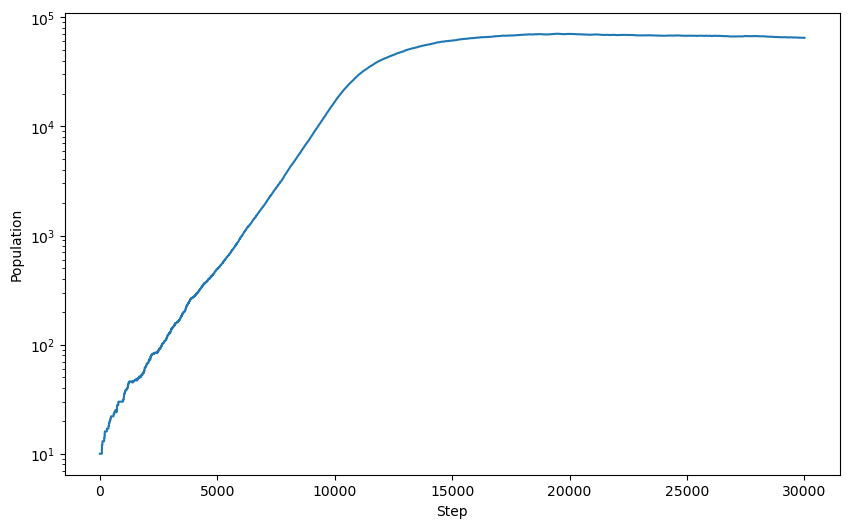

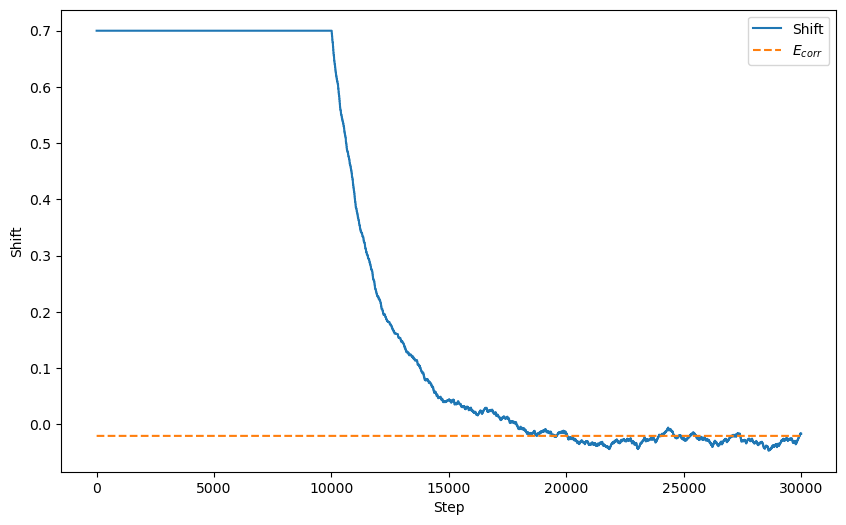

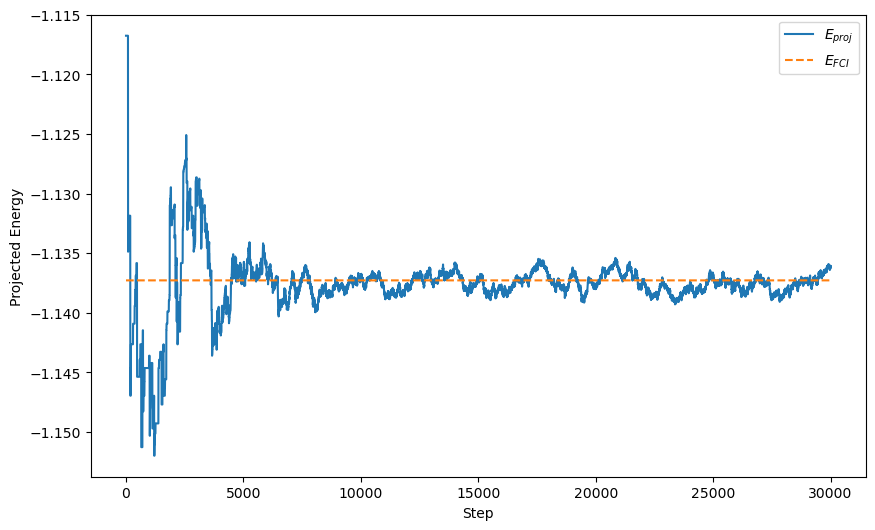

In [54]:
from pyscf import gto

# H2分子の定義 (0.74 Angstrom)
mol = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='sto-3g', verbose=0)
E_est, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, shift=0.7, init_n_walker=10, n_steps=30000, n_prod=5000, step_starting_shift_upd=10000)

print(f"E_fci={E_fci}, E_HF={E_HF}")

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"Final FCIQMC Energy: {E_est:.6f} Ha")
print(f"Average shift: {avg_shift:.6f} Ha => Energy: {avg_shift + E_HF}")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)


## ${H_3^+}$ (sto-3g)
FCI行列は9x9

converged SCF energy = -1.24591513197544
E(RMP2) = -1.26559786762945  E_corr = -0.0196827356540126
E(SCS-RMP2) = -1.26953441476026  E_corr = -0.0236192827848151
--- FCI Matrix ---
(9, 9)
[[-1.245915  0.       -0.        0.        0.144076 -0.       -0.
  -0.        0.144077]
 [ 0.       -0.616149 -0.        0.144076  0.       -0.095644 -0.
  -0.095644 -0.      ]
 [-0.       -0.       -0.616131 -0.       -0.095644 -0.        0.144077
  -0.        0.09564 ]
 [ 0.        0.144076 -0.       -0.616149  0.       -0.095644 -0.
  -0.095644 -0.      ]
 [ 0.144076  0.       -0.095644  0.        0.113702 -0.       -0.095644
  -0.        0.075887]
 [-0.       -0.095644 -0.       -0.095644 -0.       -0.03805  -0.
   0.075887 -0.      ]
 [-0.       -0.        0.144077 -0.       -0.095644 -0.       -0.616131
  -0.        0.09564 ]
 [-0.       -0.095644 -0.       -0.095644 -0.        0.075887 -0.
  -0.03805  -0.      ]
 [ 0.144077 -0.        0.09564  -0.        0.075887 -0.        0.09564
  -0.       

 13%|███████████▊                                                                               | 1938/15000 [00:00<00:01, 9233.40it/s]

Step 0: Walkers=1, Shift=1.00000, E_proj=-1.245915
  1 walkers on 0th determinant
Step 1000: Walkers=2, Shift=1.00000, E_proj=-1.389992
  1 walkers on 0th determinant
  -1 walkers on 4th determinant


 25%|██████████████████████▉                                                                    | 3779/15000 [00:00<00:01, 8371.69it/s]

Step 2000: Walkers=2, Shift=1.00000, E_proj=-1.389992
  1 walkers on 0th determinant
  -1 walkers on 4th determinant
Step 3000: Walkers=6, Shift=1.00000, E_proj=-1.274730
  5 walkers on 0th determinant
  -1 walkers on 4th determinant


 31%|████████████████████████████                                                               | 4625/15000 [00:00<00:01, 7464.69it/s]

Step 4000: Walkers=10, Shift=1.00000, E_proj=-1.266497
  7 walkers on 0th determinant
  -2 walkers on 2th determinant
  -1 walkers on 4th determinant
Step 5000: Walkers=15, Shift=0.71955, E_proj=-1.259013
  11 walkers on 0th determinant
  -3 walkers on 2th determinant
  -1 walkers on 8th determinant


 45%|████████████████████████████████████████▋                                                  | 6710/15000 [00:01<00:01, 5315.05it/s]

Step 6000: Walkers=27, Shift=0.71955, E_proj=-1.274730
  20 walkers on 0th determinant
  -3 walkers on 2th determinant
  -1 walkers on 4th determinant
  -3 walkers on 8th determinant


 52%|███████████████████████████████████████████████▎                                           | 7793/15000 [00:01<00:01, 4971.55it/s]

Step 7000: Walkers=36, Shift=-0.04080, E_proj=-1.266497
  28 walkers on 0th determinant
  -2 walkers on 2th determinant
  -2 walkers on 4th determinant
  2 walkers on 6th determinant
  -2 walkers on 8th determinant
Step 8000: Walkers=29, Shift=-0.04080, E_proj=-1.268967
  25 walkers on 0th determinant
  -4 walkers on 8th determinant


 65%|███████████████████████████████████████████████████████████                                | 9738/15000 [00:01<00:00, 5845.39it/s]

Step 9000: Walkers=35, Shift=0.15490, E_proj=-1.269928
  30 walkers on 0th determinant
  -2 walkers on 4th determinant
  -3 walkers on 8th determinant
Step 10000: Walkers=46, Shift=-0.04415, E_proj=-1.272456
  38 walkers on 0th determinant
  1 walkers on 2th determinant
  -3 walkers on 4th determinant
  -4 walkers on 8th determinant


 79%|███████████████████████████████████████████████████████████████████████▍                  | 11906/15000 [00:02<00:00, 4870.51it/s]

Step 11000: Walkers=48, Shift=-0.03674, E_proj=-1.263067
  42 walkers on 0th determinant
  1 walkers on 2th determinant
  -4 walkers on 4th determinant
  -1 walkers on 8th determinant


 83%|██████████████████████████████████████████████████████████████████████████▍               | 12399/15000 [00:02<00:00, 4710.42it/s]

Step 12000: Walkers=63, Shift=0.06428, E_proj=-1.281934
  48 walkers on 0th determinant
  3 walkers on 2th determinant
  -7 walkers on 4th determinant
  -5 walkers on 8th determinant


 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 13752/15000 [00:02<00:00, 4097.32it/s]

Step 13000: Walkers=73, Shift=0.15706, E_proj=-1.275724
  58 walkers on 0th determinant
  2 walkers on 2th determinant
  -7 walkers on 4th determinant
  1 walkers on 6th determinant
  -5 walkers on 8th determinant


 98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 14698/15000 [00:02<00:00, 4374.21it/s]

Step 14000: Walkers=75, Shift=0.02269, E_proj=-1.277132
  60 walkers on 0th determinant
  1 walkers on 2th determinant
  -6 walkers on 4th determinant
  1 walkers on 6th determinant
  -7 walkers on 8th determinant


100%|██████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [00:02<00:00, 5380.54it/s]



---- Walkers (result) ----
62 walkers on 0th determinant
-1 walkers on 2th determinant
-6 walkers on 4th determinant
-1 walkers on 6th determinant
-3 walkers on 8th determinant
------------------------------
FCI Energy: -1.274275 Ha
Final FCIQMC Energy: -1.271703 Ha


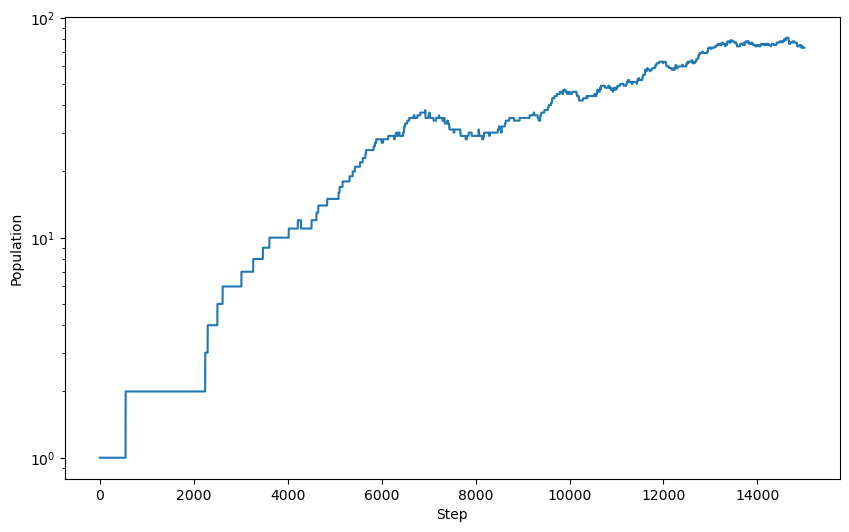

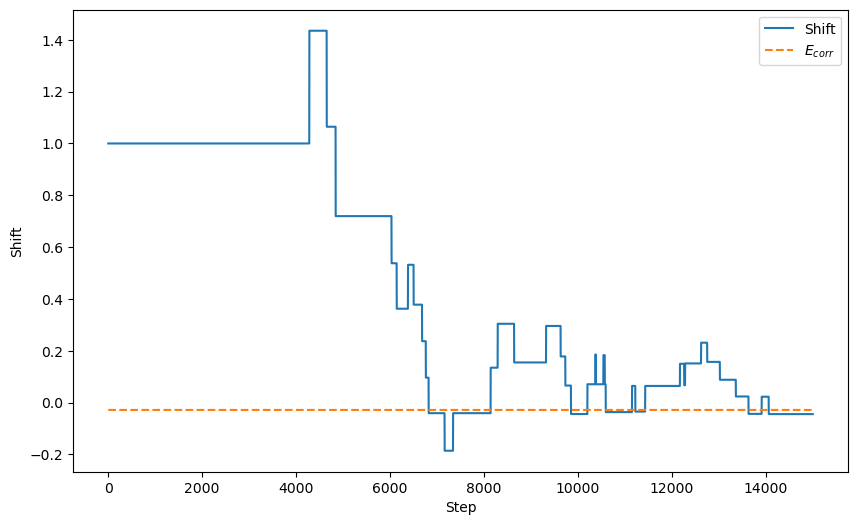

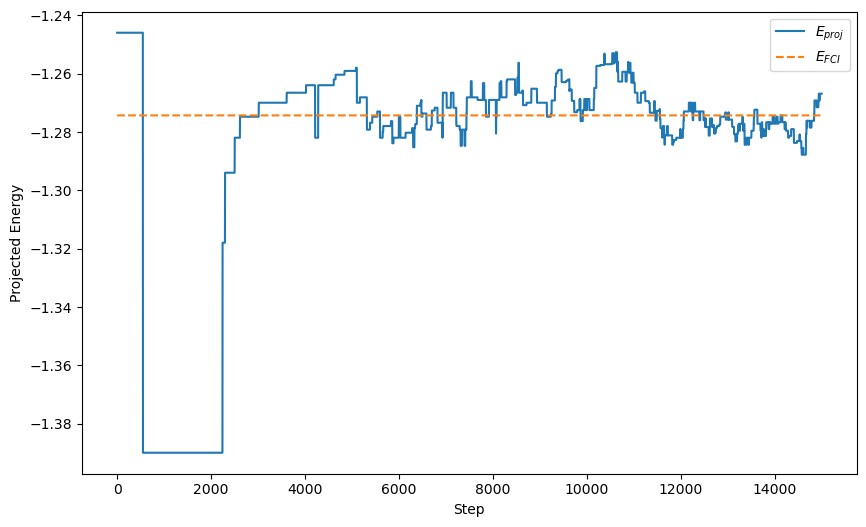

In [27]:
from pyscf import gto

# H3+分子の定義
mol = gto.M(
    atom = "H 0 0 0; H 1 0 0; H 0.5 0.866 0",
    basis = "sto-3g",
    charge = 1,
    spin = 0
)
E_est, E_fci, E_HF, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, n_steps=15000, n_prod=7000, step_starting_shift_upd=4000)

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"Final FCIQMC Energy: {E_est:.6f} Ha")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)


## ${LiH}$ (STO-3G)
FCI行列は225x225

--- FCI Matrix ---
(225, 225)
[[-8.85407204e+00  1.27143393e-08 -1.26872559e-10 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.27143393e-08 -8.70113079e+00 -1.12113377e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.26872559e-10 -1.12113377e-02 -6.80106501e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.45454152e+00
   6.33833829e-17  1.81580973e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  6.33833829e-17
  -2.40746928e+00 -1.31618634e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.81580973e-17
  -1.31618634e-17 -2.37373100e+00]]
--- K Matrix ---
[[-9.92207270e-01  1.27143393e-08 -1.26872559e-10 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.27143393e-08 -8.39266018e-01 -1.12113377e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.26872559e-10 -1.12113377e-02  1.06079976e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 .

  1%|▍                                                                                            | 157/30000 [00:00<00:37, 794.04it/s]

Step 0: Walkers=1, Shift=0.00000, E_proj=-7.861865
  1 walkers on 0th determinant


  4%|███▎                                                                                       | 1102/30000 [00:00<00:27, 1058.87it/s]

Step 1000: Walkers=4, Shift=0.00000, E_proj=-7.903174
  3 walkers on 0th determinant
  -1 walkers on 160th determinant


  7%|██████▍                                                                                     | 2097/30000 [00:03<00:58, 477.45it/s]

Step 2000: Walkers=7, Shift=0.00000, E_proj=-7.895001
  4 walkers on 0th determinant
  1 walkers on 12th determinant
  1 walkers on 111th determinant
  -1 walkers on 160th determinant


 10%|█████████▍                                                                                  | 3069/30000 [00:05<01:16, 349.76it/s]

Step 3000: Walkers=16, Shift=0.00000, E_proj=-7.871387
  9 walkers on 0th determinant
  1 walkers on 12th determinant
  -2 walkers on 15th determinant
  2 walkers on 96th determinant
  1 walkers on 111th determinant
  -1 walkers on 160th determinant


 13%|████████████▍                                                                               | 4037/30000 [00:08<01:42, 252.72it/s]

Step 4000: Walkers=38, Shift=0.00000, E_proj=-7.865770
  25 walkers on 0th determinant
  -6 walkers on 15th determinant
  -1 walkers on 16th determinant
  -1 walkers on 30th determinant
  2 walkers on 96th determinant
  1 walkers on 111th determinant
  -1 walkers on 160th determinant
  -1 walkers on 78th determinant


 17%|███████████████▍                                                                            | 5027/30000 [00:13<02:31, 165.23it/s]

Step 5000: Walkers=83, Shift=-0.35087, E_proj=-7.871674
  52 walkers on 0th determinant
  -2 walkers on 10th determinant
  -10 walkers on 15th determinant
  -2 walkers on 16th determinant
  3 walkers on 25th determinant
  -1 walkers on 30th determinant
  -1 walkers on 32th determinant
  -2 walkers on 48th determinant
  4 walkers on 96th determinant
  1 walkers on 111th determinant
  1 walkers on 151th determinant
  -3 walkers on 160th determinant
  1 walkers on 176th determinant


 20%|██████████████████▍                                                                         | 6027/30000 [00:19<02:09, 185.58it/s]

Step 6000: Walkers=126, Shift=-0.44845, E_proj=-7.879448
  82 walkers on 0th determinant
  -2 walkers on 10th determinant
  -15 walkers on 15th determinant
  -3 walkers on 16th determinant
  3 walkers on 25th determinant
  -1 walkers on 48th determinant
  4 walkers on 96th determinant
  4 walkers on 151th determinant
  -10 walkers on 160th determinant
  1 walkers on 176th determinant
  -1 walkers on 126th determinant


 23%|█████████████████████▌                                                                      | 7013/30000 [00:25<02:50, 134.62it/s]

Step 7000: Walkers=177, Shift=-0.73137, E_proj=-7.874920
  122 walkers on 0th determinant
  2 walkers on 1th determinant
  -1 walkers on 10th determinant
  -16 walkers on 15th determinant
  -5 walkers on 16th determinant
  3 walkers on 25th determinant
  1 walkers on 40th determinant
  -3 walkers on 48th determinant
  1 walkers on 49th determinant
  2 walkers on 96th determinant
  8 walkers on 151th determinant
  -9 walkers on 160th determinant
  1 walkers on 104th determinant
  1 walkers on 191th determinant
  -1 walkers on 42th determinant
  -1 walkers on 78th determinant


 27%|████████████████████████▌                                                                   | 8018/30000 [00:33<02:24, 151.75it/s]

Step 8000: Walkers=231, Shift=-0.78585, E_proj=-7.880371
  160 walkers on 0th determinant
  3 walkers on 1th determinant
  -1 walkers on 10th determinant
  -21 walkers on 15th determinant
  -7 walkers on 16th determinant
  3 walkers on 25th determinant
  -1 walkers on 26th determinant
  1 walkers on 41th determinant
  -3 walkers on 48th determinant
  -1 walkers on 49th determinant
  10 walkers on 151th determinant
  -19 walkers on 160th determinant
  1 walkers on 166th determinant


 30%|███████████████████████████▋                                                                | 9024/30000 [00:42<02:41, 129.57it/s]

Step 9000: Walkers=259, Shift=-0.84884, E_proj=-7.877302
  185 walkers on 0th determinant
  5 walkers on 1th determinant
  -3 walkers on 10th determinant
  -19 walkers on 15th determinant
  -4 walkers on 16th determinant
  4 walkers on 25th determinant
  -2 walkers on 48th determinant
  -2 walkers on 49th determinant
  2 walkers on 63th determinant
  -1 walkers on 96th determinant
  -1 walkers on 112th determinant
  10 walkers on 151th determinant
  -18 walkers on 160th determinant
  -1 walkers on 176th determinant
  -1 walkers on 181th determinant
  -1 walkers on 126th determinant


 33%|██████████████████████████████▋                                                             | 10012/30000 [00:50<03:44, 89.18it/s]

Step 10000: Walkers=295, Shift=-0.95640, E_proj=-7.874615
  212 walkers on 0th determinant
  5 walkers on 1th determinant
  -1 walkers on 10th determinant
  1 walkers on 12th determinant
  -19 walkers on 15th determinant
  -3 walkers on 16th determinant
  -2 walkers on 17th determinant
  6 walkers on 25th determinant
  -1 walkers on 26th determinant
  1 walkers on 40th determinant
  2 walkers on 41th determinant
  -2 walkers on 48th determinant
  -2 walkers on 64th determinant
  -5 walkers on 96th determinant
  3 walkers on 111th determinant
  -2 walkers on 112th determinant
  1 walkers on 150th determinant
  7 walkers on 151th determinant
  -1 walkers on 152th determinant
  -16 walkers on 160th determinant
  1 walkers on 166th determinant
  -1 walkers on 104th determinant
  -1 walkers on 182th determinant


 37%|█████████████████████████████████▍                                                         | 11013/30000 [01:00<02:43, 116.30it/s]

Step 11000: Walkers=295, Shift=-0.90514, E_proj=-7.877256
  221 walkers on 0th determinant
  5 walkers on 1th determinant
  -17 walkers on 15th determinant
  -2 walkers on 16th determinant
  -1 walkers on 17th determinant
  7 walkers on 25th determinant
  -1 walkers on 32th determinant
  -1 walkers on 41th determinant
  -3 walkers on 48th determinant
  1 walkers on 49th determinant
  -1 walkers on 96th determinant
  1 walkers on 97th determinant
  1 walkers on 150th determinant
  8 walkers on 151th determinant
  -22 walkers on 160th determinant
  2 walkers on 166th determinant
  -1 walkers on 180th determinant


 40%|████████████████████████████████████▊                                                       | 12013/30000 [01:08<03:13, 93.13it/s]

Step 12000: Walkers=324, Shift=-1.03198, E_proj=-7.884502
  227 walkers on 0th determinant
  7 walkers on 1th determinant
  -1 walkers on 10th determinant
  -14 walkers on 15th determinant
  -5 walkers on 16th determinant
  -1 walkers on 17th determinant
  4 walkers on 25th determinant
  -1 walkers on 30th determinant
  -4 walkers on 32th determinant
  1 walkers on 40th determinant
  -4 walkers on 48th determinant
  1 walkers on 63th determinant
  -1 walkers on 64th determinant
  -3 walkers on 96th determinant
  1 walkers on 97th determinant
  -1 walkers on 112th determinant
  2 walkers on 150th determinant
  9 walkers on 151th determinant
  1 walkers on 152th determinant
  -35 walkers on 160th determinant
  -1 walkers on 182th determinant


 43%|███████████████████████████████████████▌                                                   | 13023/30000 [01:16<01:51, 151.63it/s]

Step 13000: Walkers=319, Shift=-0.98350, E_proj=-7.883616
  236 walkers on 0th determinant
  7 walkers on 1th determinant
  -2 walkers on 10th determinant
  -12 walkers on 15th determinant
  -2 walkers on 16th determinant
  4 walkers on 25th determinant
  -1 walkers on 30th determinant
  -2 walkers on 32th determinant
  -6 walkers on 48th determinant
  -2 walkers on 96th determinant
  1 walkers on 150th determinant
  8 walkers on 151th determinant
  -36 walkers on 160th determinant


 47%|██████████████████████████████████████████▌                                                | 14026/30000 [01:24<01:48, 147.85it/s]

Step 14000: Walkers=315, Shift=-1.04523, E_proj=-7.878861
  235 walkers on 0th determinant
  6 walkers on 1th determinant
  -3 walkers on 10th determinant
  -11 walkers on 15th determinant
  -3 walkers on 16th determinant
  -1 walkers on 17th determinant
  6 walkers on 25th determinant
  -1 walkers on 32th determinant
  -5 walkers on 48th determinant
  -7 walkers on 96th determinant
  10 walkers on 151th determinant
  1 walkers on 152th determinant
  -25 walkers on 160th determinant
  1 walkers on 79th determinant


 50%|██████████████████████████████████████████████                                              | 15014/30000 [01:32<02:43, 91.40it/s]

Step 15000: Walkers=316, Shift=-1.05953, E_proj=-7.884895
  214 walkers on 0th determinant
  6 walkers on 1th determinant
  -2 walkers on 10th determinant
  1 walkers on 12th determinant
  -8 walkers on 15th determinant
  -7 walkers on 16th determinant
  11 walkers on 25th determinant
  1 walkers on 26th determinant
  -2 walkers on 32th determinant
  -4 walkers on 48th determinant
  3 walkers on 49th determinant
  1 walkers on 63th determinant
  -1 walkers on 96th determinant
  2 walkers on 97th determinant
  2 walkers on 150th determinant
  15 walkers on 151th determinant
  -30 walkers on 160th determinant
  1 walkers on 166th determinant
  -1 walkers on 176th determinant
  1 walkers on 180th determinant
  1 walkers on 177th determinant
  -1 walkers on 113th determinant
  -1 walkers on 79th determinant


 53%|████████████████████████████████████████████████▌                                          | 16017/30000 [01:41<01:46, 131.19it/s]

Step 16000: Walkers=296, Shift=-1.06026, E_proj=-7.883191
  213 walkers on 0th determinant
  5 walkers on 1th determinant
  -1 walkers on 10th determinant
  -5 walkers on 15th determinant
  -4 walkers on 16th determinant
  9 walkers on 25th determinant
  -6 walkers on 48th determinant
  2 walkers on 63th determinant
  -9 walkers on 96th determinant
  1 walkers on 111th determinant
  10 walkers on 151th determinant
  -28 walkers on 160th determinant
  -1 walkers on 167th determinant
  1 walkers on 176th determinant
  1 walkers on 181th determinant


 57%|███████████████████████████████████████████████████▌                                       | 17018/30000 [01:49<01:45, 122.68it/s]

Step 17000: Walkers=280, Shift=-1.02521, E_proj=-7.879261
  205 walkers on 0th determinant
  4 walkers on 1th determinant
  -1 walkers on 2th determinant
  -2 walkers on 15th determinant
  -1 walkers on 16th determinant
  10 walkers on 25th determinant
  -8 walkers on 48th determinant
  2 walkers on 63th determinant
  -10 walkers on 96th determinant
  12 walkers on 151th determinant
  -19 walkers on 160th determinant
  1 walkers on 166th determinant
  1 walkers on 175th determinant
  -1 walkers on 180th determinant
  -2 walkers on 198th determinant
  -1 walkers on 50th determinant


 60%|██████████████████████████████████████████████████████▋                                    | 18015/30000 [01:58<01:50, 108.48it/s]

Step 18000: Walkers=294, Shift=-0.95530, E_proj=-7.882046
  210 walkers on 0th determinant
  4 walkers on 1th determinant
  -1 walkers on 2th determinant
  1 walkers on 10th determinant
  1 walkers on 12th determinant
  -1 walkers on 15th determinant
  -2 walkers on 16th determinant
  11 walkers on 25th determinant
  1 walkers on 26th determinant
  1 walkers on 40th determinant
  -6 walkers on 48th determinant
  -12 walkers on 96th determinant
  -1 walkers on 97th determinant
  -1 walkers on 112th determinant
  1 walkers on 150th determinant
  16 walkers on 151th determinant
  -23 walkers on 160th determinant
  -1 walkers on 198th determinant


 63%|█████████████████████████████████████████████████████████▋                                 | 19018/30000 [02:07<01:41, 108.27it/s]

Step 19000: Walkers=311, Shift=-1.00509, E_proj=-7.883105
  216 walkers on 0th determinant
  5 walkers on 1th determinant
  2 walkers on 11th determinant
  1 walkers on 12th determinant
  -2 walkers on 15th determinant
  -5 walkers on 16th determinant
  12 walkers on 25th determinant
  -1 walkers on 30th determinant
  -1 walkers on 32th determinant
  -10 walkers on 48th determinant
  1 walkers on 49th determinant
  -9 walkers on 96th determinant
  2 walkers on 97th determinant
  -1 walkers on 150th determinant
  15 walkers on 151th determinant
  -25 walkers on 160th determinant
  -1 walkers on 181th determinant
  1 walkers on 191th determinant
  1 walkers on 80th determinant


 67%|████████████████████████████████████████████████████████████▋                              | 20018/30000 [02:15<01:09, 143.90it/s]

Step 20000: Walkers=292, Shift=-0.93723, E_proj=-7.879098
  220 walkers on 0th determinant
  7 walkers on 1th determinant
  -2 walkers on 16th determinant
  7 walkers on 25th determinant
  -6 walkers on 48th determinant
  1 walkers on 49th determinant
  -9 walkers on 96th determinant
  2 walkers on 97th determinant
  1 walkers on 111th determinant
  12 walkers on 151th determinant
  -22 walkers on 160th determinant
  1 walkers on 161th determinant
  1 walkers on 192th determinant
  -1 walkers on 128th determinant


 70%|███████████████████████████████████████████████████████████████▋                           | 21011/30000 [02:22<01:15, 118.38it/s]

Step 21000: Walkers=313, Shift=-0.95337, E_proj=-7.880519
  236 walkers on 0th determinant
  7 walkers on 1th determinant
  2 walkers on 15th determinant
  -4 walkers on 16th determinant
  8 walkers on 25th determinant
  -4 walkers on 48th determinant
  -1 walkers on 63th determinant
  -8 walkers on 96th determinant
  1 walkers on 111th determinant
  -1 walkers on 112th determinant
  9 walkers on 151th determinant
  -28 walkers on 160th determinant
  1 walkers on 180th determinant
  -1 walkers on 181th determinant
  -1 walkers on 216th determinant
  1 walkers on 78th determinant


 73%|███████████████████████████████████████████████████████████████████▍                        | 22010/30000 [02:31<01:26, 91.91it/s]

Step 22000: Walkers=343, Shift=-1.00004, E_proj=-7.883808
  242 walkers on 0th determinant
  7 walkers on 1th determinant
  -7 walkers on 16th determinant
  10 walkers on 25th determinant
  1 walkers on 26th determinant
  -1 walkers on 31th determinant
  -1 walkers on 32th determinant
  -5 walkers on 48th determinant
  2 walkers on 49th determinant
  1 walkers on 63th determinant
  -9 walkers on 96th determinant
  2 walkers on 97th determinant
  4 walkers on 111th determinant
  1 walkers on 150th determinant
  10 walkers on 151th determinant
  -33 walkers on 160th determinant
  1 walkers on 166th determinant
  -2 walkers on 176th determinant
  -1 walkers on 181th determinant
  -1 walkers on 191th determinant
  -1 walkers on 113th determinant
  1 walkers on 218th determinant


 77%|██████████████████████████████████████████████████████████████████████▌                     | 23008/30000 [02:42<01:11, 98.00it/s]

Step 23000: Walkers=345, Shift=-1.00005, E_proj=-7.884495
  247 walkers on 0th determinant
  5 walkers on 1th determinant
  3 walkers on 10th determinant
  -7 walkers on 16th determinant
  6 walkers on 25th determinant
  -1 walkers on 32th determinant
  -1 walkers on 41th determinant
  -5 walkers on 48th determinant
  2 walkers on 49th determinant
  -9 walkers on 96th determinant
  1 walkers on 97th determinant
  1 walkers on 111th determinant
  2 walkers on 150th determinant
  13 walkers on 151th determinant
  -36 walkers on 160th determinant
  1 walkers on 167th determinant
  -2 walkers on 104th determinant
  -1 walkers on 181th determinant
  1 walkers on 119th determinant
  -1 walkers on 78th determinant


 80%|████████████████████████████████████████████████████████████████████████▊                  | 24015/30000 [02:52<00:51, 116.98it/s]

Step 24000: Walkers=346, Shift=-0.98753, E_proj=-7.884177
  246 walkers on 0th determinant
  8 walkers on 1th determinant
  -2 walkers on 10th determinant
  -7 walkers on 16th determinant
  -1 walkers on 17th determinant
  11 walkers on 25th determinant
  -1 walkers on 32th determinant
  -8 walkers on 48th determinant
  1 walkers on 49th determinant
  1 walkers on 63th determinant
  -9 walkers on 96th determinant
  1 walkers on 111th determinant
  14 walkers on 151th determinant
  1 walkers on 152th determinant
  -33 walkers on 160th determinant
  -1 walkers on 113th determinant
  1 walkers on 126th determinant


 83%|███████████████████████████████████████████████████████████████████████████▉               | 25020/30000 [03:02<00:39, 125.11it/s]

Step 25000: Walkers=339, Shift=-0.94289, E_proj=-7.880550
  250 walkers on 0th determinant
  7 walkers on 1th determinant
  1 walkers on 2th determinant
  -3 walkers on 10th determinant
  5 walkers on 15th determinant
  -7 walkers on 16th determinant
  11 walkers on 25th determinant
  1 walkers on 26th determinant
  -2 walkers on 48th determinant
  -8 walkers on 96th determinant
  1 walkers on 97th determinant
  1 walkers on 111th determinant
  10 walkers on 151th determinant
  -29 walkers on 160th determinant
  -1 walkers on 176th determinant
  1 walkers on 162th determinant
  1 walkers on 144th determinant


 87%|██████████████████████████████████████████████████████████████████████████████▉            | 26014/30000 [03:09<00:39, 100.56it/s]

Step 26000: Walkers=391, Shift=-0.93754, E_proj=-7.882149
  276 walkers on 0th determinant
  8 walkers on 1th determinant
  -1 walkers on 10th determinant
  5 walkers on 15th determinant
  -5 walkers on 16th determinant
  13 walkers on 25th determinant
  -1 walkers on 31th determinant
  -1 walkers on 32th determinant
  -9 walkers on 48th determinant
  4 walkers on 63th determinant
  -9 walkers on 96th determinant
  3 walkers on 111th determinant
  -1 walkers on 112th determinant
  -2 walkers on 150th determinant
  14 walkers on 151th determinant
  -33 walkers on 160th determinant
  1 walkers on 166th determinant
  1 walkers on 167th determinant
  -1 walkers on 175th determinant
  2 walkers on 192th determinant
  1 walkers on 134th determinant


 90%|██████████████████████████████████████████████████████████████████████████████████▊         | 27011/30000 [03:18<00:31, 93.86it/s]

Step 27000: Walkers=421, Shift=-0.95968, E_proj=-7.882871
  301 walkers on 0th determinant
  11 walkers on 1th determinant
  1 walkers on 10th determinant
  1 walkers on 12th determinant
  4 walkers on 15th determinant
  -8 walkers on 16th determinant
  18 walkers on 25th determinant
  1 walkers on 26th determinant
  -5 walkers on 48th determinant
  2 walkers on 49th determinant
  1 walkers on 63th determinant
  -7 walkers on 96th determinant
  1 walkers on 97th determinant
  -2 walkers on 150th determinant
  13 walkers on 151th determinant
  -39 walkers on 160th determinant
  -1 walkers on 165th determinant
  -1 walkers on 167th determinant
  1 walkers on 180th determinant
  -1 walkers on 27th determinant
  -1 walkers on 104th determinant
  1 walkers on 192th determinant


 93%|████████████████████████████████████████████████████████████████████████████████████▉      | 28010/30000 [03:29<00:19, 103.30it/s]

Step 28000: Walkers=429, Shift=-1.01880, E_proj=-7.885938
  304 walkers on 0th determinant
  6 walkers on 1th determinant
  -1 walkers on 2th determinant
  5 walkers on 15th determinant
  -10 walkers on 16th determinant
  14 walkers on 25th determinant
  -2 walkers on 32th determinant
  -6 walkers on 48th determinant
  3 walkers on 49th determinant
  2 walkers on 63th determinant
  -3 walkers on 64th determinant
  -4 walkers on 96th determinant
  1 walkers on 97th determinant
  1 walkers on 111th determinant
  -2 walkers on 150th determinant
  15 walkers on 151th determinant
  -47 walkers on 160th determinant
  1 walkers on 175th determinant
  -1 walkers on 104th determinant
  1 walkers on 190th determinant


 97%|████████████████████████████████████████████████████████████████████████████████████████▉   | 29011/30000 [03:40<00:11, 82.65it/s]

Step 29000: Walkers=416, Shift=-0.99128, E_proj=-7.885412
  290 walkers on 0th determinant
  3 walkers on 1th determinant
  6 walkers on 15th determinant
  -5 walkers on 16th determinant
  13 walkers on 25th determinant
  -1 walkers on 30th determinant
  -1 walkers on 31th determinant
  -2 walkers on 32th determinant
  1 walkers on 40th determinant
  -8 walkers on 48th determinant
  3 walkers on 63th determinant
  -11 walkers on 96th determinant
  1 walkers on 111th determinant
  -1 walkers on 112th determinant
  20 walkers on 151th determinant
  1 walkers on 152th determinant
  -41 walkers on 160th determinant
  1 walkers on 166th determinant
  -1 walkers on 176th determinant
  1 walkers on 180th determinant
  -1 walkers on 27th determinant
  -1 walkers on 58th determinant
  1 walkers on 192th determinant
  -1 walkers on 50th determinant
  1 walkers on 199th determinant


100%|███████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [03:50<00:00, 130.15it/s]



---- Walkers (result) ----
296 walkers on 0th determinant
4 walkers on 1th determinant
1 walkers on 2th determinant
-1 walkers on 10th determinant
1 walkers on 12th determinant
8 walkers on 15th determinant
-9 walkers on 16th determinant
15 walkers on 25th determinant
-1 walkers on 30th determinant
1 walkers on 40th determinant
-6 walkers on 48th determinant
1 walkers on 49th determinant
-7 walkers on 96th determinant
2 walkers on 97th determinant
1 walkers on 111th determinant
15 walkers on 151th determinant
-35 walkers on 160th determinant
-1 walkers on 58th determinant
-1 walkers on 104th determinant
-1 walkers on 191th determinant
1 walkers on 42th determinant
1 walkers on 200th determinant
1 walkers on 80th determinant
------------------------------
FCI Energy: -7.882324 Ha
Final FCIQMC Energy: -7.883022 Ha


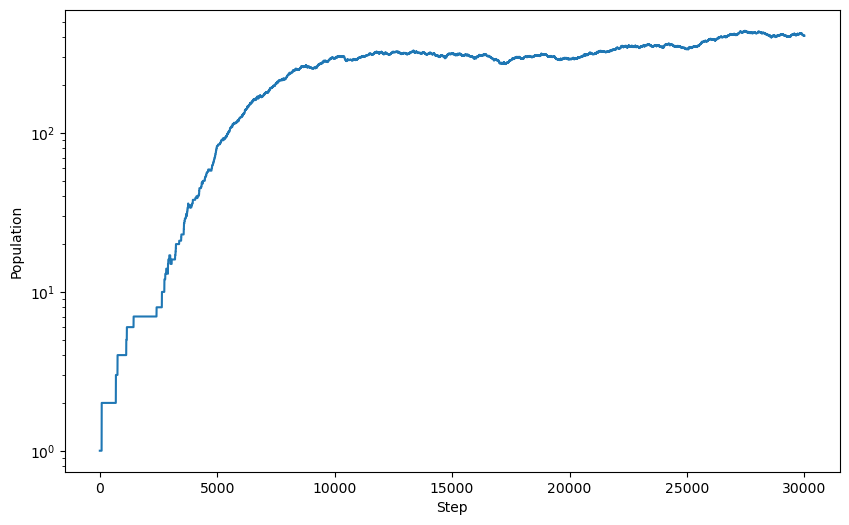

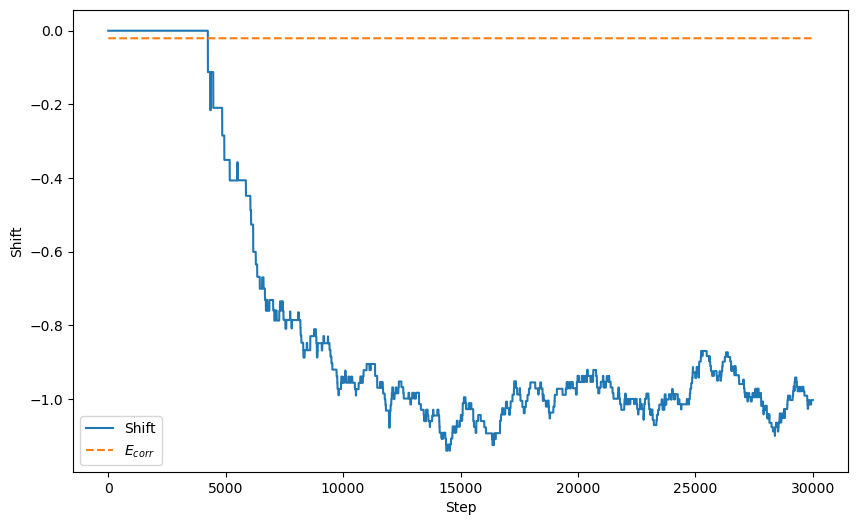

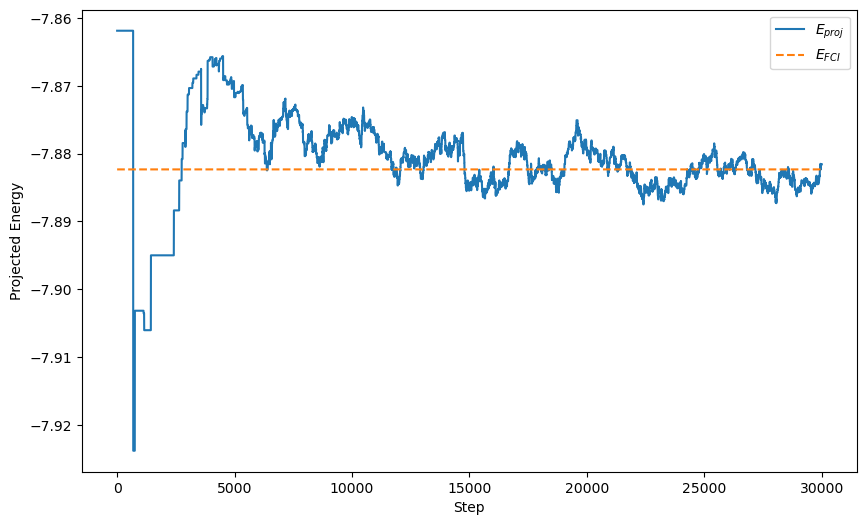

In [5]:
from pyscf import gto

# LiH分子の定義
mol = gto.M(
    atom=f"Li 0 0 0; H 0 0 1.6",
    basis="sto-3g",
    spin=0,      # singlet
    verbose=0
)
E_est, E_fci, E_HF, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, n_steps=30000, n_prod=10000, step_starting_shift_upd=4000)

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"Final FCIQMC Energy: {E_est:.6f} Ha")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)


## ${N_2}$ at equilibrium
FCI行列が巨大過ぎて生成出来ない。必要な成分のみ取ってくる実装（on the fly?）に変える必要がありそう

In [ ]:
from pyscf import gto

# N2 at equilibriumの定義
R_bohr = 2.068     # a0
R_ang = R_bohr * 0.529177

mol = gto.M(
    atom=f"N 0 0 0; N 0 0 {R_ang}",
    basis="cc-pVDZ",
    unit="Angstrom",
    spin=0,      # singlet
    verbose=0
)
E_est, E_fci, E_HF, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, n_steps=1000, n_prod=500, step_starting_shift_upd=100)

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"Final FCIQMC Energy: {E_est:.6f} Ha")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)
